In [10]:
import sys
sys.path.append("/home/till/Desktop/GitHub/self-driving-car/")
sys.path.append("/home/till/Desktop/GitHub/self-driving-car/weights")

In [4]:
import logging
import os
import random
import sys
from collections import deque
from operator import itemgetter

import gym_donkeycar
import gymnasium as gym
import imageio
import ipywidgets as widgets
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from IPython.display import display
from ipywidgets import HBox, VBox
from matplotlib import pyplot as plt
from PIL import Image
from ruamel.yaml import YAML
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm
from tensorboard import notebook
from tensorboard.backend.event_processing.event_accumulator import \
    EventAccumulator
from torch import distributions as dist
from torch.distributions import Categorical, Normal
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm

import gym.spaces as gym_spaces
import gymnasium as gym  # overwrite OpenAI gym

# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="gymnasium.spaces.box") # module="gymnasium"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["IMAGEIO_IGNORE_WARNINGS"] = "True"

import stable_baselines3 as sb3
from gym_donkeycar.envs.donkey_env import DonkeyEnv
from gymnasium import spaces
from gymnasium.spaces import Box
from stable_baselines3 import A2C, PPO, SAC
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

from src.actor_critic_discrete import DiscreteActorCritic
from src.actor_critic_dreamer import ActorCriticDreamer
from src.actor_critic import ContinuousActorCritic
from src.blocks import CategoricalStraightThrough, ConvBlock
from src.categorical_vae import CategoricalVAE
from src.imagination_env import make_imagination_env
from src.mlp import MLP
from src.preprocessing import transform
from src.replay_buffer import ReplayBuffer
from src.rssm import RSSM
from src.utils import (load_config, make_env, save_image_and_reconstruction,
                       to_np, symlog, symexp, twohot_encode, ExponentialMovingAvg,
                       ActionExponentialMovingAvg)
from src.vae import VAE

torch.cuda.empty_cache()
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load the config
config = load_config()
for key in config:
    locals()[key] = config[key]

In [21]:
agent = DiscreteActorCritic()
agent.load_weights("/home/till/Desktop/GitHub/self-driving-car/weights/DiscreteActorCritic_0")
agent.action_ema.decay = torch.tensor(0.5).to(device)

Adding zero weight init to the output layer.


In [22]:
# you need to modify the get_action returns to this for this code to work:
#
# return action, log_prob, actor_entropy, action_target 
#

In [68]:
# set up action EMAs
action_ema_08 = ActionExponentialMovingAvg(n_actions=1)
action_ema_08.decay = torch.tensor(0.8).to(device)

action_ema_095 = ActionExponentialMovingAvg(n_actions=1)
action_ema_095.decay = torch.tensor(0.95).to(device)

# set up the env
env = gym.make("Pendulum-v1", render_mode="human")

value_preds = []

actions_05 = []
actions_08 = []
actions_095 = []

action_targets = []

obs, info = env.reset()

for i in range(80):
    # get acton target and action05
    action, _, _, action_target = agent.get_action(obs)
    action_targets.append(action_target)
    
    # get other actions
    action_08 = action_ema_08.get_ema_action(action_target)
    action_095 = action_ema_095.get_ema_action(action_target)
    
    value_pred, _ = agent.apply_critic(obs)
    value_preds.append(value_pred)
    obs, _, _, _, _ = env.step(to_np(action))
    
    actions_05.append(action)
    actions_08.append(action_08)
    actions_095.append(action_095)
    

env.close()
# plt.plot(to_np(torch.stack(value_preds)))

actions_05 = to_np(torch.stack(actions_05))
actions_08 = to_np(torch.stack(actions_08))
actions_095 = to_np(torch.stack(actions_095))
action_targets = to_np(torch.stack(action_targets))

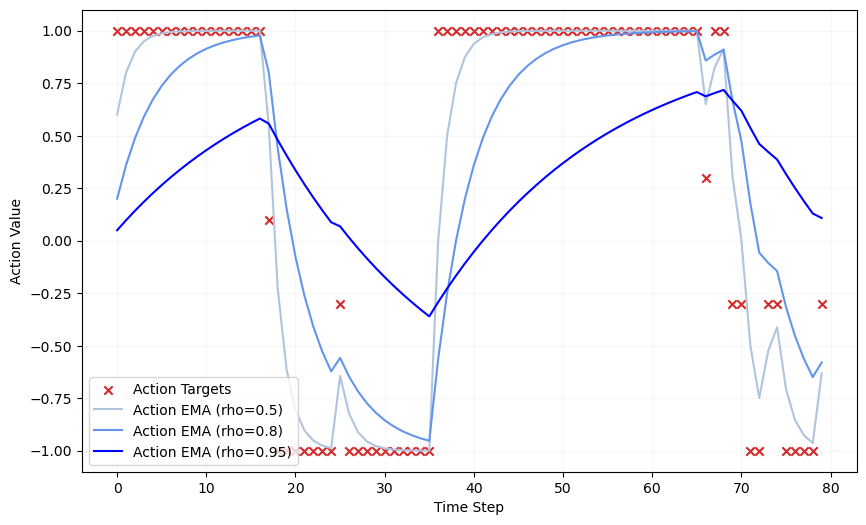

In [70]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(np.arange(len(action_targets)), action_targets, label="Action Targets",
           color='tab:red', marker='x')

ax.plot(actions_05, label="Action EMA (rho=0.5)", linestyle='-', color="lightsteelblue")
ax.plot(actions_08, label="Action EMA (rho=0.8)", linestyle='-', color="cornflowerblue")
ax.plot(actions_095, label="Action EMA (rho=0.95)", linestyle='-', color="blue")

ax.set_xlabel("Time Step")
ax.set_ylabel("Action Value")

ax.legend(loc="lower left") # , bbox_to_anchor=(1.23, 1)
ax.grid(True, alpha=0.1)
#plt.savefig("/home/till/Desktop/GitHub/self-driving-car/figs/action_ema4.pdf")
plt.show()